In [1]:
import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from shutil import copyfile
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Create Directories

In [2]:
os.makedirs("images")
image_info = pd.read_csv("../input/yum-or-yuck-butterfly-mimics-2022/data/butterfly_mimics/images.csv")

In [3]:
def _copy_images(images, source_dir, destination):
    for im in images:
        copyfile(os.path.join(source_dir, f"{im}.jpg"),
                os.path.join(destination, f"{im}.jpg"))

In [4]:
%%time
classes = image_info.name.unique()

for species in classes:
    os.makedirs(f"images/training/{species}")
    os.makedirs(f"images/validation/{species}")
    
    subset = image_info[image_info.name==species]
    train, val = train_test_split(subset, test_size=0.2)
    train_images = list(train.image)
    val_images = list(val.image)
    print(f"******** {species}")
    print(f"Train size is: {len(train_images)}")
    print(f"Test size is: {len(val_images)}")
    _copy_images(train_images, f"../input/yum-or-yuck-butterfly-mimics-2022/data/butterfly_mimics/images/", f"./images/training/{species}/")
    _copy_images(val_images, f"../input/yum-or-yuck-butterfly-mimics-2022/data/butterfly_mimics/images/", f"./images/validation/{species}/")

******** monarch
Train size is: 105
Test size is: 27
******** tiger
Train size is: 121
Test size is: 31
******** black
Train size is: 128
Test size is: 32
******** pipevine
Train size is: 153
Test size is: 39
******** viceroy
Train size is: 87
Test size is: 22
******** spicebush
Train size is: 86
Test size is: 22
CPU times: user 126 ms, sys: 162 ms, total: 288 ms
Wall time: 7.21 s


In [5]:
# for dirname, _, filenames in os.walk('./images'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Generators:

In [6]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    directory="./images/training/",
    batch_size=32,
    class_mode="categorical",
    target_size=(224, 224)
)

val_generator = val_datagen.flow_from_directory(
    directory="./images/validation",
    batch_size=32,
    class_mode="categorical",
    target_size=(224, 224)
)

Found 680 images belonging to 6 classes.
Found 173 images belonging to 6 classes.


# Model:

In [12]:
inputs = tf.keras.layers.Input(shape=(224, 224, 3))
base_model = tf.keras.applications.xception.Xception(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet")
# base_model = tf.keras.applications.vgg19.VGG19(
#     input_shape=(224,224,3),
#     include_top=False,
#     weights="imagenet")
# base_model = tf.keras.applications.resnet50.ResNet50(
#     input_shape=(224,224,3),
#     include_top=False,
#     weights="imagenet")
# base_model = tf.keras.applications.efficientnet.EfficientNetB1(
#     input_shape=(224,224,3),
#     include_top=False,
#     weights="imagenet")
for layer in base_model.layers:
    layer.trainable = False
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1024, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(64, activation="relu")(x)
output = tf.keras.layers.Dense(6, activation="softmax")(x)
model = tf.keras.Model(inputs=inputs, outputs=output)
print(model.summary())

83697664/83683744 [==============================] - 1s 0us/step
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
xception (Functional)        (None, 7, 7, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
____________________________________________________________

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss="categorical_crossentropy",
    metrics="accuracy",
)
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=20,
    restore_best_weights=True
)
history = model.fit(train_generator,
          validation_data = val_generator,
          epochs = 200,
         callbacks=[stop_early])

Epoch 1/200
22/22 [==============================] - 13s 448ms/step - loss: 1.3910 - accuracy: 0.4191 - val_loss: 1.0670 - val_accuracy: 0.5260
Epoch 2/200
22/22 [==============================] - 9s 409ms/step - loss: 1.0169 - accuracy: 0.5529 - val_loss: 0.9241 - val_accuracy: 0.6243
Epoch 3/200
22/22 [==============================] - 10s 435ms/step - loss: 0.8249 - accuracy: 0.6397 - val_loss: 0.8198 - val_accuracy: 0.6301
Epoch 4/200
22/22 [==============================] - 9s 407ms/step - loss: 0.8210 - accuracy: 0.6265 - val_loss: 0.8323 - val_accuracy: 0.6185
Epoch 5/200
22/22 [==============================] - 9s 393ms/step - loss: 0.7582 - accuracy: 0.6632 - val_loss: 0.6801 - val_accuracy: 0.7746
Epoch 6/200
22/22 [==============================] - 9s 403ms/step - loss: 0.7403 - accuracy: 0.6824 - val_loss: 0.7074 - val_accuracy: 0.7688
Epoch 7/200
22/22 [==============================] - 9s 420ms/step - loss: 0.6860 - accuracy: 0.7118 - val_loss: 0.6949 - val_accuracy: 0.78

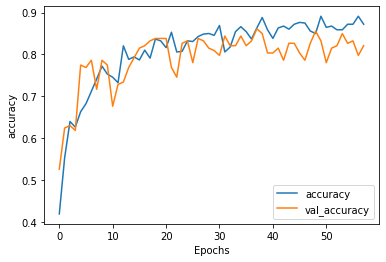

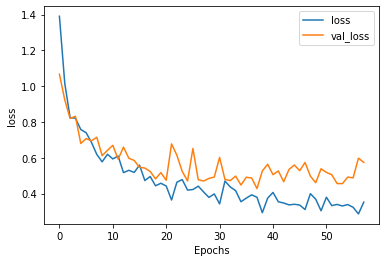

In [14]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, f'val_{metric}'])
    plt.show()
    
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Testing:

In [64]:
test_info = pd.read_csv("../input/yum-or-yuck-butterfly-mimics-2022/data/butterfly_mimics/image_holdouts.csv")

In [65]:
def read_test_data(df):
    test_images = []
    for im in test_info.image:
        img = cv2.imread(f"../input/yum-or-yuck-butterfly-mimics-2022/data/butterfly_mimics/image_holdouts/{im}.jpg")
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        test_images.append(img)
    return np.stack(test_images)

In [66]:
test_data = read_test_data(test_info)

In [67]:
norm_test_data = test_data / 255

In [68]:
predictions = model.predict(norm_test_data)

In [69]:
predictions_argmax = np.argmax(predictions, axis=1)

In [70]:
classes = train_generator.class_indices
processed_preds = [list(classes.keys())[list(classes.values()).index(v)] for v in predictions_argmax]

In [71]:
test_info['name'] = processed_preds

In [72]:
test_info.to_csv("submission.csv", index=False)